# **Sentiment Analysis in Python: Hotel Reviews Data**

In this project, I develop a sentiment analysis model to predict the rating of hotel reviews based on their review titles. The dataset used in this analysis consists of 1,000 hotels and their reviews, provided by [Datafiniti’s Business Database](https://data.world/datafiniti/hotel-reviews). The goal is to determine whether a review’s rating is less than 3, equal to 3, or greater than 3 by analyzing the sentiment expressed in the review title.

This project demonstrates how textual data can be used to predict sentiment. The sentiment classification is achieved using a multiclass logistic regression model that categorizes the ratings into three distinct classes. The analysis also explores the feature importance, highlighting the words and phrases most impactful in determining the sentiment, and visualizes the prediction process, model performance, and rating distributions.

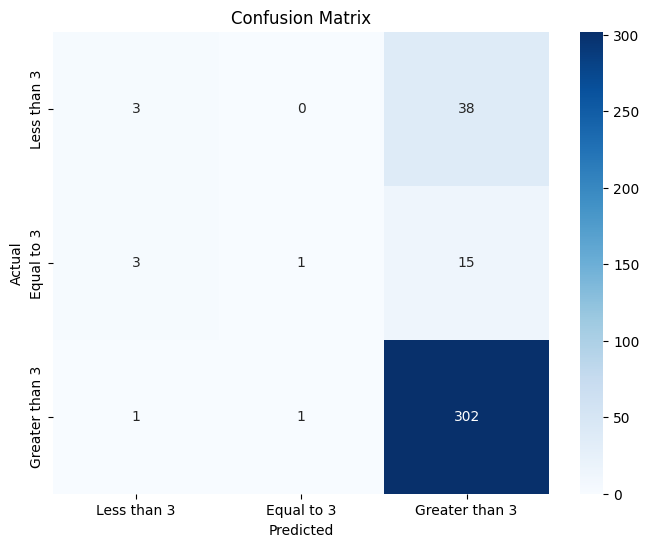

In [8]:
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

#Load dataset
df = pd.read_csv('Datafiniti_Hotel_Reviews.csv')

#Preprocess data: clean the text
def preprocess_text(text):
    #Handle any non-string values
    if not isinstance(text, str):
        return ""  #Return an empty string if the value is not a string

    text = text.lower() #Lowercase
    text = re.sub(f"[{re.escape(string.punctuation)}]", "", text) #Remove punctuation
    text = re.sub("\s+", " ", text).strip() #Remove extra spaces
    return text

df['reviews.title'] = df['reviews.title'].apply(preprocess_text)

# Convert ratings to categorical labels
def categorize_rating(rating):
    if rating < 3:
        return 'less_than_3'
    elif rating == 3:
        return 'equal_to_3'
    else:
        return 'greater_than_3'

df['rating_category'] = df['reviews.rating'].apply(categorize_rating)

#Visualize distribution of original/actual ratings
plt.figure(figsize=(10, 5))
sns.countplot(df['rating_category'], order=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.title('Distribution of Rating Categories')
plt.xlabel('Rating Category')
plt.ylabel('Count')
plt.show()

#Vectorize text data using TF-IDF vectorization: convert the text data into numerical form.
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['reviews.title'])

#Train classification model: split the data into training and testing sets, then train a model. The model we'll use is logistic regression.

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, df['rating_category'], test_size=0.2, random_state=42)

# Train the model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train)

#Evaluate model
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

#Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred, labels=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Less than 3', 'Equal to 3', 'Greater than 3'], yticklabels=['Less than 3', 'Equal to 3', 'Greater than 3'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

#Visualize distribution of predicted ratings
predicted_categories = pd.Series(y_pred, name='Predicted Rating Category')
plt.figure(figsize=(10, 5))
sns.countplot(predicted_categories, order=['less_than_3', 'equal_to_3', 'greater_than_3'])
plt.title('Distribution of Predicted Rating Categories')
plt.xlabel('Predicted Rating Category')
plt.ylabel('Count')
plt.show()

# Feature importance visualization (top 20 features)
feature_names = vectorizer.get_feature_names_out()
coefficients = model.coef_.flatten()
top_features = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)[:20]
top_feature_names = [x[1] for x in top_features]
top_feature_values = [x[0] for x in top_features]

plt.figure(figsize=(10, 8))
sns.barplot(x=top_feature_values, y=top_feature_names)
plt.title('Top 20 Features Impacting Ratings')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature Name')
plt.show()

#Example prediction
new_review_title = "Worst hotel in town"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")
#The model gives an unreasonable prediction of the class of this review; the sentiment of the review is negative, and the model predicts that
#the review will have an associated rating that is greater than 3 (positive sentiment).

#Example prediction
new_review_title = "Hotel is just okay"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")

#Example prediction
new_review_title = "Best hotel in town"
processed_title = preprocess_text(new_review_title)
title_vector = vectorizer.transform([processed_title])
predicted_category = model.predict(title_vector)

print(f"Review Title: {new_review_title}")
print(f"Predicted Rating Category: {predicted_category[0]}")



The model makes poor predictions for reviews with negative sentiment. The low f1-scores of the "less than three" and "equal to three" classes indicate low accuracy for the predictions of those classes. I believe the low f-1 scores are caused by an imbalance in the dataset. Most ratings are greater than 3 (positive sentiment). The "greater than three" class has a high f-1 score, while the other two classes have low scores. The overall accuracy of the model is fairly high. These metrics show how the model is biased to classify a review as the majority
class. The accuracy score of the model, ~0.84 (total number of correct predictions, 306, divided by the total number of predictions, 364), is fairly high, even though the model fails to accurately predict the class of most negative reviews. The disparity in the precision scores between the categories shows the bias in the model. Because the data is imabalanced, the f-1 scores are a better metric for evaluating reliability of the model. The confusion matrix shows that only 1/19 reviews that are actually equal to 3 were correctly preedited, and only 3/41 reviews that are actually less than three were correctly predicted. Meanwhile, 302/304 reviews that are actually greater than 3 were correctly predicted.

One way to handle the imbalanced data would be to employ the Synthetic Minority Oversampling Technique, or SMOTE.